In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import pybel
from collections import defaultdict
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from torch_geometric.data import Data
import numpy as np
import pickle

In [2]:
import sys
sys.path.append('../evaluation/')

In [3]:
from utils_eval import build_pdb_dict
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from data_processing.utils import ATOM_TYPE_MAPPING, PP_TYPE_MAPPING, ATOM_FAMILIES, MAP_ATOM_TYPE_AROMATIC_TO_INDEX
from data_processing.paired_data import CombinedSparseGraphDataset

In [4]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 600

In [5]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'

pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [6]:
# pdb_dict.values()

In [7]:
# names = pdb_dict.keys()
# pdb_ids = [name.split('_')[0] for name in names]
# pdb_ids

name_list = pdb_dict.values()
pdb_ids = []
for names in name_list:
    # ids = set([name.split('_')[0] for name in names])
    ids = set([ligand_name[ligand_name.rfind('rec')+4:ligand_name.rfind('rec')+8] for ligand_name in names])
    pdb_ids += ids
pdb_ids

['4idt',
 'v_13',
 '4idv',
 't_t2',
 '5_ag',
 'pdb',
 '5nzo',
 'p_9e',
 'c_na',
 'q_5a',
 '5ofv',
 '5ofw',
 'm_9t',
 '5nzq',
 'o_9e',
 '5nzp',
 '3_8n',
 '5ofm',
 'w_9t',
 'pdb',
 'v_9t',
 'g_am',
 'g_ad',
 '3feg',
 'pdb',
 'i_10',
 '1kpi',
 'm_d2',
 'pdb',
 'b_31',
 '3bl9',
 '7_dd',
 'e_30',
 '4qeb',
 'a_dd',
 '0_gt',
 '4qde',
 '4_gt',
 'm_m7',
 'v_30',
 '9_dd',
 'pdb',
 '2wm3',
 '3_nf',
 'd_zz',
 '2wmd',
 'pdb',
 '4jao',
 'pdb',
 'o_pl',
 '3_pl',
 'c_xb',
 '1rsc',
 'l_ca',
 '1rbl',
 'pdb',
 'i_8z',
 '5v7i',
 'pdb',
 '4if7',
 '8_t0',
 '7_fc',
 '3pka',
 '3iu8',
 '3pkb',
 '3iu9',
 '7_hc',
 'a_y0',
 '3iu7',
 'y_he',
 'c_y0',
 'b_y1',
 '9_t0',
 'd_y1',
 '3pkd',
 'pdb',
 'q_w2',
 '3_jj',
 '4_es',
 '2yjd',
 'e_19',
 '4j24',
 'n_ra',
 '2jj3',
 'd_yj',
 '3oll',
 '1l2j',
 '1qkm',
 '1hj1',
 'm_ge',
 '1u3s',
 '1u3q',
 '1qkn',
 'z_oh',
 '1x7j',
 'q_27',
 'e_39',
 '2qtu',
 '8_24',
 'y_su',
 'u_fb',
 'j_ge',
 's_79',
 'x_es',
 '1x78',
 's_es',
 '2giu',
 '1u3r',
 'e_mo',
 '5toa',
 '2fsz',
 'f_78',
 '

In [8]:
['1ywn', '2euf', '6b8y', '3pxz']

['1ywn', '2euf', '6b8y', '3pxz']

In [9]:
'6b8y' in pdb_ids

False

In [10]:
ligand_name = '4dtk_A_rec_5eol_5qo_lig_tt_min_0'
ligand_name[ligand_name.rfind('rec')+4:ligand_name.rfind('rec')+8]

'5eol'

In [11]:
pdb_id2filename = defaultdict(lambda : [])
for k in pdb_rev_dict.keys():
    pdb_id = k[k.rfind('rec')+4:k.rfind('rec')+8]
    pdb_id2filename[pdb_id].append(k)

In [12]:
pdb_id2filename

defaultdict(<function __main__.<lambda>()>,
            {'4idv': ['4idv_B_rec_4idv_13v_lig_tt_min_0.sdf',
              '4idt_A_rec_4idv_13v_lig_tt_docked_12.sdf',
              '4g3d_A_rec_4idv_13v_lig_tt_docked_7.sdf',
              '4idt_A_rec_4idv_13v_lig_tt_min_0.sdf',
              '4idv_B_rec_4idv_13v_lig_tt_docked_0.sdf',
              '4g3d_A_rec_4idv_13v_lig_tt_min_0.sdf'],
             'v_13': ['4idv_13v_lig.pdb'],
             '4idt': ['4idv_B_rec_4idt_t28_lig_tt_min_0.sdf',
              '4dn5_A_rec_4idt_t28_lig_tt_docked_1.sdf',
              '4g3d_A_rec_4idt_t28_lig_tt_min_0.sdf',
              '4idt_A_rec_4idt_t28_lig_tt_min_0.sdf',
              '4dn5_A_rec_4idt_t28_lig_tt_min_0.sdf',
              '4g3d_A_rec_4idt_t28_lig_tt_docked_2.sdf',
              '4idt_A_rec_4idt_t28_lig_tt_docked_0.sdf'],
             'pdb': ['4dn5_A_rec.pdb',
              '4idt_A_rec.pdb',
              '4g3d_A_rec.pdb',
              '4idv_B_rec.pdb',
              '5n53_B_rec.pdb',
       

In [13]:
pdb_id2filename['1ywn']

['3ewh_A_rec_1ywn_lif_lig_tt_docked_0.sdf',
 '3be2_A_rec_1ywn_lif_lig_tt_docked_0.sdf',
 '3be2_A_rec_1ywn_lif_lig_tt_min_0.sdf',
 '1ywn_A_rec_1ywn_lif_lig_tt_min_0.sdf',
 '1ywn_A_rec_1ywn_lif_lig_tt_docked_0.sdf',
 '3ewh_A_rec_1ywn_lif_lig_tt_min_0.sdf']

In [46]:
# ligand_filename = '1ywn_A_rec_1ywn_lif_lig_tt_docked_0.sdf'
# ligand_filename = '4b81_B_rec_4ara_c56_lig_tt_min_0.sdf'
# ligand_filename = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0.sdf'
# ligand_filename = '1lhu_A_rec_1lhn_aon_lig_tt_min_0.sdf'
# ligand_filename = '5hbh_A_rec_5idn_6a7_lig_tt_min_0.sdf'
# ligand_filename = '4b84_A_rec_4b84_z5k_lig_tt_min_0.sdf'
# ligand_filename = '4yyz_B_rec_3ey4_352_lig_tt_docked_12.sdf'
# ligand_filename = '5aen_A_rec_5ni2_dj3_lig_tt_min_0.sdf'
# ligand_filename = '3d3e_B_rec_4ijw_1eq_lig_tt_min_0.sdf'
# ligand_filename = '3ey4_C_rec_4k1l_sff_lig_tt_min_0.sdf'
# ligand_filename = '4h7c_A_rec_3r58_nps_lig_tt_min_0.sdf'

# ligand_filename = '3hfg_A_rec_3hfg_17r_lig_tt_min_0.sdf'
# ligand_filename = '3ey4_C_rec_5pgu_8k4_lig_tt_min_0.sdf'
# ligand_filename = '5ni2_A_rec_5aen_dp8_lig_tt_min_0.sdf'
# ligand_filename = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0.sdf'
# ligand_filename = '4yyz_B_rec_2ilt_nn1_lig_tt_min_0.sdf'
# ligand_filename = '4bnn_A_rec_4bnm_tcu_lig_tt_min_0.sdf'
# ligand_filename = '4yvx_A_rec_1s2a_imn_lig_tt_min_0.sdf'
# ligand_filename = '3czr_B_rec_4bb5_hd2_lig_tt_min_0.sdf'
# ligand_filename = '3czr_A_rec_2ilt_nn1_lig_tt_min_0.sdf'
# ligand_filename = '4b84_A_rec_4btl_5gz_lig_tt_min_0.sdf'
# ligand_filename = '3fue_A_rec_3ftv_11x_lig_tt_min_0.sdf'
# ligand_filename = '4bnk_B_rec_4d44_ja3_lig_tt_min_0.sdf'
# ligand_filename = '3qqp_B_rec_4k1l_sff_lig_tt_min_0.sdf'
# ligand_filename = '4wdu_A_rec_3r94_flr_lig_tt_min_0.sdf'
# ligand_filename = '4alj_A_rec_4bnf_pv4_lig_tt_docked_0.sdf'
# ligand_filename = '1ejj_A_rec_1o99_2pg_lig_tt_docked_0.sdf'
# ligand_filename = '4h96_B_rec_4h95_06u_lig_tt_min_0.sdf'
# ligand_filename = '2oa6_D_rec_4kvi_1sv_lig_tt_min_0.sdf'
# ligand_filename = '4hx5_B_rec_3bzu_a21_lig_tt_min_0.sdf'
# ligand_filename = '5pgy_D_rec_3bzu_a21_lig_tt_min_0.sdf'
# ligand_filename = '5pgv_A_rec_3bzu_a21_lig_tt_min_0.sdf'
# ligand_filename = '4kux_B_rec_4kvw_jf4_lig_tt_min_0.sdf'
# ligand_filename = '4bnk_B_rec_4bnl_w1g_lig_tt_min_0.sdf'
# ligand_filename = '4b82_B_rec_4ara_c56_lig_tt_min_0.sdf'
# ligand_filename = '4pm0_A_rec_4y2b_epk_lig_tt_min_0.sdf'
# ligand_filename = '4ms6_A_rec_3fuh_5h1_lig_tt_min_0.sdf'
# ligand_filename = '5ivg_B_rec_4kvy_jf1_lig_tt_docked_9.sdf'
# ligand_filename = '3r8h_A_rec_3r8h_zom_lig_tt_min_0.sdf'
# ligand_filename = '1aoe_A_rec_3qlr_qlr_lig_tt_docked_4.sdf'
# ligand_filename = '2ilt_A_rec_3ey4_352_lig_tt_min_0.sdf'
# ligand_filename = '2g1q_A_rec_1x88_nat_lig_tt_min_0.sdf'
# ligand_filename = '5imp_B_rec_4kwd_jf2_lig_tt_min_0.sdf'
# ligand_filename = '4d45_A_rec_4ali_tcl_lig_tt_min_0.sdf'
# ligand_filename = '5ivg_B_rec_4kvw_jf4_lig_tt_min_0.sdf'
ligand_filename = '2rbe_C_rec_3byz_h11_lig_tt_min_0.sdf'

ligand_path = os.path.join(raw_data_path, pdb_rev_dict[ligand_filename])
ligand_path

'../../data/cleaned_crossdocked_data/raw/DHI1_HUMAN_22_291_0'

In [47]:
# test_mol = Chem.MolFromSmiles('CC(=O)O')
# test_mol = Chem.MolFromSmiles('C1=C(C(=O)NC(=O)N1)F')
# test_mol = Chem.AddHs(test_mol)
# params = AllChem.ETKDGv3()
# params.randomSeed = 0xf00d # optional random seed for reproducibility
# AllChem.EmbedMolecule(test_mol, params)
# test_mol

In [48]:
# ligand_path = '../evaluation/ligand_based/test5'
# ligand_file = os.path.join(ligand_path, 'test5.sdf')
# os.makedirs(ligand_path, exist_ok = True)
# print(Chem.MolToMolBlock(test_mol),file=open(ligand_file, 'w+'))

ligand_file = os.path.join(ligand_path, ligand_filename)
ligand_file

'../../data/cleaned_crossdocked_data/raw/DHI1_HUMAN_22_291_0/2rbe_C_rec_3byz_h11_lig_tt_min_0.sdf'

In [49]:
rdmol = Chem.MolFromMolFile(ligand_file, removeHs=False, sanitize=True)
pbmol = next(pybel.readfile("sdf", ligand_file))
try:
    rdmol = Chem.AddHs(rdmol)
    ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False)
    rdmol = ligand.rdmol_noH
except Exception as e:
    print(f'Ligand {ligand_path} init failed')
    print(e)

In [50]:
ligand.pharmacophore_list

[('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868cc10>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868dd50>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868dd20>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868dcf0>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868dbd0>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868dc60>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868f8b0>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868dfc0>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868fe50>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868f4f0>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f6da868ee00>),
 ('HBond_donor',
  <data_process

In [51]:
def group_by(mol, ligand, level='pp'):
    my_cmap = matplotlib.colormaps['coolwarm']
#     my_cmap = cm.get_cmap('coolwarm')
    if level == 'cluster':
        n_group = len(ligand.graph.node_clusters)
    elif level == 'pp':
        n = 0
        for cluster in ligand.graph.node_clusters:
            n += cluster.positions.shape[1]
        n_group = n
        # pp_id = 0
        
    my_norm = Normalize(vmin=0, vmax=n_group)
    atommap, bondmap = {}, {}
    for i in range(len(ligand.graph.node_clusters)):
        cluster = ligand.graph.node_clusters[i]
        for node in cluster.nodes:
#             node = cluster.nodes[pp_id]
            atom_idx = node.atom_indices
            if level == 'cluster':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(i))
                atommap.update({atom_id:my_cmap(my_norm(i))[:3] for atom_id in atom_idx})
            elif level == 'pp':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(node.index))
                atommap.update({atom_id:my_cmap(my_norm(node.index))[:3] for atom_id in atom_idx})
                # pp_id += 1
                
    highlights = {
        "highlightAtoms": list(atommap.keys()),
        "highlightAtomColors": atommap,
        "highlightBonds": list(bondmap.keys()),
        "highlightBondColors": bondmap,
    }
    mol_ = rdMolDraw2D.PrepareMolForDrawing(mol)
    imgsize = (600, 300)
    drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
    drawer.DrawMolecule(mol_, **highlights)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))

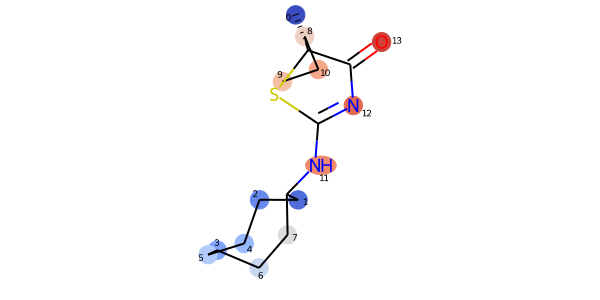

In [52]:
group_by(rdmol, ligand)

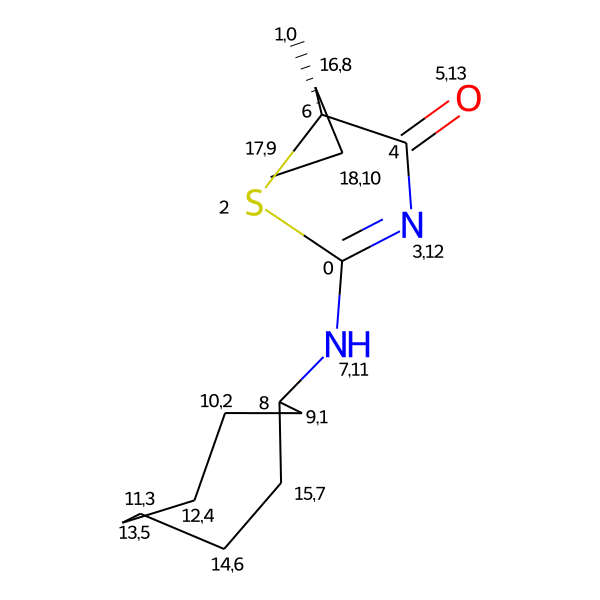

In [53]:
rdmol

In [54]:
for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[ 4.8822  2.0853 12.2937]
['Hydrophobic'] 0
[1]
[ 4.959  -3.9282 13.9778]
['Hydrophobic'] 1
[9]
[ 3.7058 -3.9265 14.8433]
['Hydrophobic'] 2
[10]
[ 2.3258 -5.5653 12.6564]
['Hydrophobic'] 3
[11]
[ 3.2072 -5.3479 15.0622]
['Hydrophobic'] 4
[12]
[ 2.0324 -5.7127 14.1498]
['Hydrophobic'] 5
[13]
[ 3.6896 -6.1404 12.2964]
['Hydrophobic'] 6
[14]
[ 4.6176 -5.0641 11.7328]
['Hydrophobic'] 7
[15]
[ 5.1746  1.3824 14.6564]
['Hydrophobic'] 8
[16]
[ 4.4479 -0.0833 16.5185]
['Hydrophobic'] 9
[17]
[ 5.6179  0.3104 15.6428]
['Hydrophobic'] 10
[18]
[ 5.51   -2.8052 11.8965]
['HBond_donor', 'HBond_acceptor'] 11
[7]
[ 6.7554 -0.8605 12.3818]
['HBond_acceptor'] 12
[3]
[ 7.6747  1.2064 12.9605]
['HBond_acceptor'] 13
[5]


In [55]:
# selected = [2, 4, 12, 13, 14, 15, 22, 23, 25, 27]
# selected = [0, 2, 3]

# selected = [0, 3, 4, 5]
# selected = [1, 2, 3, 4, 5]
# selected = [2]

In [56]:
# selected_pp = [ligand.graph.nodes[i] for i in selected]

# selected_pp = ligand.graph.nodes
# selected_pp

In [57]:
all_pp = []
for i, node in enumerate(ligand.graph.nodes):
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
#     print(pp_type, atom_indices)
    all_pp.append([node.types, atom_indices, i])
all_pp = Ligand.remove_overlapping_pp(all_pp)
all_pp
# ligand.pharmacophore_list = Ligand.remove_overlapping_pp(ligand.pharmacophore_list)
# ligand.graph.nodes

[[['Hydrophobic'], [1], 0],
 [['Hydrophobic'], [9], 1],
 [['Hydrophobic'], [10], 2],
 [['Hydrophobic'], [11], 3],
 [['Hydrophobic'], [12], 4],
 [['Hydrophobic'], [13], 5],
 [['Hydrophobic'], [14], 6],
 [['Hydrophobic'], [15], 7],
 [['Hydrophobic'], [16], 8],
 [['Hydrophobic'], [17], 9],
 [['Hydrophobic'], [18], 10],
 [['HBond_donor', 'HBond_acceptor'], [7], 11],
 [['HBond_acceptor'], [3], 12],
 [['HBond_acceptor'], [5], 13]]

In [58]:
selected = [pp[2] for pp in all_pp]
selected

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [59]:
selected_pp = [ligand.graph.nodes[i] for i in selected]
selected_pp

[LigandNode(0)['Hydrophobic'],
 LigandNode(1)['Hydrophobic'],
 LigandNode(2)['Hydrophobic'],
 LigandNode(3)['Hydrophobic'],
 LigandNode(4)['Hydrophobic'],
 LigandNode(5)['Hydrophobic'],
 LigandNode(6)['Hydrophobic'],
 LigandNode(7)['Hydrophobic'],
 LigandNode(8)['Hydrophobic'],
 LigandNode(9)['Hydrophobic'],
 LigandNode(10)['Hydrophobic'],
 LigandNode(11)['HBond_donor', 'HBond_acceptor'],
 LigandNode(12)['HBond_acceptor'],
 LigandNode(13)['HBond_acceptor']]

In [60]:
def extract_pp(selected_pp, num_class):
    pp_type_mapping = PP_TYPE_MAPPING

    atom_indice_list = []
    position_list = []
    pp_type_list = []
    pp_index_list = []
    
    for pp_node in selected_pp:
        atom_indices = list([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else list(sorted(pp_node.atom_indices))
        positions = pp_node.positions.squeeze()
        index = pp_node.index
        # types = [one_hot_encoding[type] for type in pp_node.types]
        types = pp_type_mapping[pp_node.types[0]]  # we can't have multiple types for one pharmacophore, so we just take the first one

        atom_indice_list.append(atom_indices)
        position_list.append(positions)
        pp_index_list.append(index)
        pp_type_list.append(types)

    # atom_indices_tensor = torch.tensor(atom_indice_list, dtype=torch.long)
    positions_tensor = torch.tensor(np.array(position_list), dtype=torch.float)
    # one_hot_pp_tensor = torch.nn.functional.one_hot(torch.tensor(pp_type_list, dtype=torch.long), num_classes=len(pp_type_mapping.keys())).to(torch.float)
    one_hot_pp_tensor = torch.nn.functional.one_hot(torch.tensor(np.array(pp_type_list), dtype=torch.long), num_classes=num_class).to(torch.float)
    pp_index_tensor = torch.tensor(np.array(pp_index_list), dtype=torch.long)

    return atom_indice_list, positions_tensor, one_hot_pp_tensor, pp_index_tensor

## Feature dim: 12
***We are currently testing the model that is trained on aromatic data***

In [61]:
num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(MAP_ATOM_TYPE_AROMATIC_TO_INDEX.keys()))
pp_atom_indices, pp_positions, pp_types, pp_index = extract_pp(selected_pp, num_feat_class)

In [62]:
pp_types

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [63]:
def compute_target(x, pos, pp_atom_indices, pp_positions, pp_types, pp_index, center_tensor, noise_std=0.01):
        '''
            Compute the target of the diffusion bridge, which is each atom's feat/pos destination regarding its pharmacophore membership
            Should we include a bit noise when initializing the target pos?
            TODO: We don't move the CoM to zero during data preparation now, should initiate the target pos as CoM rather than zeros!!! But then how do we init the target pos during sampling stage?
        '''

        target_x = torch.zeros(x.size(0), x.size(1))
        target_pos = torch.zeros(pos.size(0), pos.size(1))
        node_pp_index = torch.zeros(x.size(0), dtype=torch.long)
        atom_in_pp = []

        for atom_indices in pp_atom_indices:
            atom_in_pp += atom_indices
        
        if len(atom_in_pp) != x.size(0):
            # some atoms are not in any pharmacophore, we cluster them and set their target pos to the cluster center
            non_pp_atom_indices, non_pp_group_center_positions = CombinedSparseGraphDataset.cluster_non_pp(pos, atom_in_pp)
        else:
            # all atoms are in pharmacophores
            non_pp_atom_indices = {}
            non_pp_group_center_positions = None
        for i in range(x.size(0)):
            if i not in atom_in_pp:  # if the atom is not in any pharmacophore, we set its target type to Linker:0 and target position to CoM plus a bit noise
                target_x[i] = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=pp_types.size(1)).to(torch.float)
                # target_pos[i] = torch.zeros(pos.size(1))
                # target_pos[i] = center_tensor + torch.randn_like(center_tensor) # * noise_std
                node_pp_index[i] = -1
                for j, atom_indices in non_pp_atom_indices.items():
                    if i in atom_indices:
                        target_pos[i] = non_pp_group_center_positions[j] + torch.randn_like(non_pp_group_center_positions[j]) * noise_std
                        break
            else:  # if the atom is in a pharmacophore, we set its target type to the pharmacophore type and target position to the pharmacophore position
                for j, atom_indices in enumerate(pp_atom_indices):
                    if i in atom_indices:
                        target_x[i] = pp_types[j]
                        target_pos[i] = pp_positions[j] + torch.randn_like(pp_positions[j]) * noise_std
                        node_pp_index[i] = j    # = pp_index[j]
                        break
        
        # if args.augment_noise > 0:
        #     # Add noise eps ~ N(0, augment_noise) around points.
        #     eps = sample_center_gravity_zero_gaussian_with_mask(x.size(), x.device, node_mask)
        #     x = x + eps * args.augment_noise

        return target_x, target_pos, node_pp_index

In [64]:
def process_one(aromatic, rdmol, selected_pp, filename):
    if aromatic:
        num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(MAP_ATOM_TYPE_AROMATIC_TO_INDEX.keys()))
    else:
        num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(ATOM_TYPE_MAPPING.keys()))
    try:
        x, x_aromatic, atomic_numbers, pos, num_nodes = CombinedSparseGraphDataset.extract_atom_features(rdmol, num_feat_class, aromatic=aromatic)

    except KeyError as e:  # some elements are not considered, skip such ligands
        print(f'Ligand contains rare elements: {e}')
    try:
        pp_atom_indices, pp_positions, pp_types, pp_index = extract_pp(selected_pp, num_feat_class)
        assert pp_positions.size(1) == 3
    except Exception as e:
        print('extract pp failed')
        print(e)
    
    pp_center_tensor = CombinedSparseGraphDataset.compute_pp_center(pp_positions)
    # print(pp_center_tensor.size())
    assert pp_center_tensor.size(0) == 3
    
    if aromatic:
        feat = x_aromatic
    else:
        feat = x

    target_x, target_pos, node_pp_index = compute_target(feat, pos, pp_atom_indices, pp_positions, pp_types, pp_index, pp_center_tensor)
    x_ctr, pos_ctr, Gt_mask = CombinedSparseGraphDataset.combine_target(feat, pos, target_x, target_pos)
    target_x_ctr, target_pos_ctr, _ = CombinedSparseGraphDataset.combine_target(target_x, target_pos, target_x, target_pos)

    data = Data(x=x_ctr, pos=pos_ctr, target_x=target_x_ctr, target_pos=target_pos_ctr, Gt_mask=Gt_mask, ligand_name=filename)

    return data

In [65]:
aromatic = False
data = process_one(aromatic, rdmol, selected_pp, filename = ligand_filename.split('.')[0])
# data = process_one(aromatic, rdmol, selected_pp, filename = 'test5')

In [ ]:
data

In [ ]:
save_path = '../evaluation/ligand_based'
# foldername = ligand_filename[ligand_filename.rfind('rec')+4:ligand_filename.rfind('rec')+8]
foldername = ligand_filename.split('.')[0]
# save_fn = ligand_filename.split('.')[0] + '_aromatic.pt' if aromatic else ligand_filename.split('.')[0] + '.pt'

# foldername = 'test5'
save_fn = foldername + '_aromatic.pt' if aromatic else foldername + '.pt'

In [ ]:
os.makedirs(os.path.join(save_path, foldername), exist_ok=True)
torch.save(data, os.path.join(save_path, foldername, save_fn))

In [ ]:
data.target_x

In [39]:
pp_info = {
    'pp_types': pp_types, 
    'pp_positions': pp_positions
}

pp_info

{'pp_types': tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'pp_positions': tensor([[-34.1836,  17.9506,  40.1831],
         [-33.3494,  19.2109,  40.0358],
         [-32.0140,  18.9209,  39.3673],
         [-30.0972,  17.4008,  39.1553],
         [-30.7589,  18.2571,  41.3993],
         [-30.0665,  17.1417,  42.1718],
         [-30.97

In [40]:
with open(os.path.join(save_path, foldername, 'pp_info.pkl'), 'wb') as f:
    pickle.dump(pp_info, f)